<a href="https://colab.research.google.com/github/lamineia/Diabets/blob/master/Copie_de_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install unidecode

     |████████████████████████████████| 245kB 13.9MB/s 


In [ ]:
#transformation
import numpy as np
import unidecode
from re import sub

#viz (learning curve)
import matplotlib.pyplot as plt
%matplotlib inline

#modélisation
from keras.models import *
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

#génération de texte
import random

#sauvegarde
from keras.callbacks import ModelCheckpoint
import json

In [ ]:
#importation du fichier texte avec l'encodage lié, passage en minuscules
raw_text = open("victorhugo.txt", 'r', encoding='utf-8').read().lower() 

raw_text = unidecode.unidecode(raw_text) #suppression des accents
#sub : ca va ciblé le traitement mot par mot
#pattern va chercher toute les valeurs digital et on remplace avec rien
raw_text = sub(pattern=r"\d", repl=r"", string=raw_text) #suppression caractères numériques
#suppression de certains caractères spéciaux (pas tous, sinon utilisation d'une regex)
raw_text = raw_text.replace(">", "")
raw_text = raw_text.replace("<", "")
raw_text = raw_text.replace("!", "")
raw_text = raw_text.replace("?", "")
raw_text = raw_text.replace("-", "")
raw_text = raw_text.replace("$", "")
raw_text = raw_text.replace(";", "")
raw_text = raw_text.replace(":", "")

raw_text = raw_text.strip() #suppression des espaces inutiles
print(raw_text[:1000])

parce que, jargonnant vepres, jeune et vigile,
exploitant dieu qui reve au fond du firmament,
vous avez, au milieu du divin evangile,
ouvert boutique effrontement 

parce que vous feriez prendre a jesus la verge,
cyniques brocanteurs sortis on ne sait d'ou 
parce que vous allez vendant la sainte vierge
dix sous avec miracle, et sans miracle un sou 

parce que vous contez d'effroyables sornettes
qui font des temples saints trembler les vieux piliers 
parce que votre style eblouit les lunettes
des duegnes et des marguilliers 

parce que la soutane est sous vos redingotes,
parce que vous sentez la crasse et non l'oeillet,
parce que vous baclez un journal de bigotes
pense par escobar, ecrit par patouillet 

parce qu'en balayant leurs portes, les concierges
poussent dans le ruisseau ce pamphlet meprise 
parce que vous melez a la cire des cierges
votre affreux suif vertdegrise 

parce qu'a vous tout seuls vous faites une espece
parce qu'enfin, blanchis dehors et noirs dedans,
criant mea culp

###Transformer les données
dict caractère/num et num/caractère
ils nous serviront à encoder/decoder le text d'entrainement et le text généré

In [ ]:
print('corpus length:', len(raw_text)) #nombres de caractères dans le texte


corpus length: 125813


In [ ]:
chars = sorted(list(set(raw_text))) #liste de caractères uniques
print('total chars:', len(chars)) #nb de caractères uniques
char_indices = dict((c, i) for i, c in enumerate(chars)) #création dictionnaire "caractère : numéro"
indices_char = dict((i, c) for i, c in enumerate(chars)) #création dictionnaire "numéro : caractère"
#enregistrement des dictionnaires créés en local
#dumps = exporté
#w = fichier texte
with open("model_rnn_char_indices", "w") as f:
    f.write(json.dumps(char_indices))
with open("model_rnn_indices_char", "w") as f:
    f.write(json.dumps(indices_char))


total chars: 32


Dans la boucle suivante, nous créons les séquences qui, une fois encodées seront utilisées comme input pour notre modèle


In [ ]:
maxlen = 40  #longueur de 40 caractères
step = 3     #step tous les 3 caractères
#sentences = input
#next_chars = output
sentences = []
next_chars = []

#création de la séquence d'entrée et séquence suivante
for i in range(0, len(raw_text) - maxlen, step +1):
    sentences.append(raw_text[i: i + maxlen])
    next_chars.append(raw_text[i + maxlen])

print('nb sequences:', len(sentences))
print(sentences)

nb sequences: 31444
['parce que, jargonnant vepres, jeune et v', 'e que, jargonnant vepres, jeune et vigil', 'e, jargonnant vepres, jeune et vigile,\ne', 'argonnant vepres, jeune et vigile,\nexplo', 'nnant vepres, jeune et vigile,\nexploitan', 't vepres, jeune et vigile,\nexploitant di', 'pres, jeune et vigile,\nexploitant dieu q', ', jeune et vigile,\nexploitant dieu qui r', 'une et vigile,\nexploitant dieu qui reve ', 'et vigile,\nexploitant dieu qui reve au f', 'igile,\nexploitant dieu qui reve au fond ', 'e,\nexploitant dieu qui reve au fond du f', 'xploitant dieu qui reve au fond du firma', 'itant dieu qui reve au fond du firmament', 't dieu qui reve au fond du firmament,\nvo', 'eu qui reve au fond du firmament,\nvous a', 'ui reve au fond du firmament,\nvous avez,', 'eve au fond du firmament,\nvous avez, au ', 'au fond du firmament,\nvous avez, au mili', 'ond du firmament,\nvous avez, au milieu d', 'du firmament,\nvous avez, au milieu du di', 'irmament,\nvous avez, au milieu du di

In [ ]:
#vectorisation (one hot encoding)
#zeros = il crée des 0
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence): # chars: list des caractères unique
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [ ]:
x.shape

(31444, 40, 32)

In [ ]:
y.shape

(31444, 32)

Créer une sauvegarde locale pour conservé les meilleurs poids générés par le RNN.
La sauvegardde se fait uniquement en cas de diminution de score de loss.


In [ ]:
filepath="weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
callbacks_list = [ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')]
#forme d'enregistrement, selon la loss, exprimé par écriture, uniquement lors d'amélioration, "min" = for loss this should be min

Là, c'est une fonction qui permet d'arreter l'entrainement lorsque la loss ne s'est pas améliorée après 100 epochs

In [ ]:
early_stop = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100)

In [ ]:
# build the model: a single LSTM
model = Sequential()
model.add(LSTM(81, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 81)                36936     
_________________________________________________________________
dense (Dense)                (None, 32)                2624      
Total params: 39,560
Trainable params: 39,560
Non-trainable params: 0
_________________________________________________________________


### Entrainer un RNN à prédire le prochain caractère

In [ ]:
model.fit(x, y, batch_size=32, epochs=500, validation_split=0.5, callbacks=[callbacks_list, early_stop])

Epoch 1/500
492/492 [==============================] - 11s 8ms/step - loss: 2.5883 - accuracy: 0.2478 - val_loss: 2.1449 - val_accuracy: 0.3366

Epoch 00001: loss improved from inf to 2.34318, saving model to weights-improvement-01-2.3432-bigger.hdf5
Epoch 2/500
492/492 [==============================] - 3s 7ms/step - loss: 2.0357 - accuracy: 0.3648 - val_loss: 2.0424 - val_accuracy: 0.3575

Epoch 00002: loss improved from 2.34318 to 2.02719, saving model to weights-improvement-02-2.0272-bigger.hdf5
Epoch 3/500
492/492 [==============================] - 3s 7ms/step - loss: 1.9166 - accuracy: 0.3954 - val_loss: 1.9758 - val_accuracy: 0.3860

Epoch 00003: loss improved from 2.02719 to 1.89507, saving model to weights-improvement-03-1.8951-bigger.hdf5
Epoch 4/500
492/492 [==============================] - 3s 7ms/step - loss: 1.7593 - accuracy: 0.4441 - val_loss: 1.9745 - val_accuracy: 0.3917

Epoch 00004: loss improved from 1.89507 to 1.78715, saving model to weights-improvement-04-1.7872

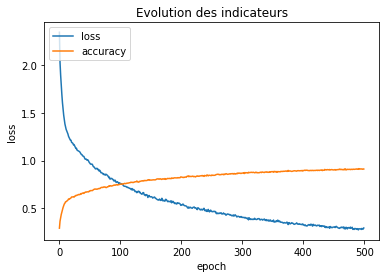

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['accuracy'])
plt.title('Evolution des indicateurs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()

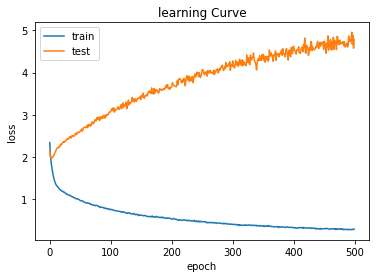

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('learning Curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# plus proche de 1.0 plus la prediction est bonne 
def sample_index(preds, temperature = 1.0): #On prend comme température de 1
    preds = np.asarray(preds).astype('float64') #On chance en float
    preds = np.log(preds) / temperature 
    exp_preds = np.exp(preds) 
    preds = exp_preds / np.sum(exp_preds) 
    probas = np.random.multinomial(1, preds, 1) 
    return np.argmax(probas) 

In [ ]:
raw_text

'parce que, jargonnant vepres, jeune et vigile,\nexploitant dieu qui reve au fond du firmament,\nvous avez, au milieu du divin evangile,\nouvert boutique effrontement \n\nparce que vous feriez prendre a jesus la verge,\ncyniques brocanteurs sortis on ne sait d\'ou \nparce que vous allez vendant la sainte vierge\ndix sous avec miracle, et sans miracle un sou \n\nparce que vous contez d\'effroyables sornettes\nqui font des temples saints trembler les vieux piliers \nparce que votre style eblouit les lunettes\ndes duegnes et des marguilliers \n\nparce que la soutane est sous vos redingotes,\nparce que vous sentez la crasse et non l\'oeillet,\nparce que vous baclez un journal de bigotes\npense par escobar, ecrit par patouillet \n\nparce qu\'en balayant leurs portes, les concierges\npoussent dans le ruisseau ce pamphlet meprise \nparce que vous melez a la cire des cierges\nvotre affreux suif vertdegrise \n\nparce qu\'a vous tout seuls vous faites une espece\nparce qu\'enfin, blanchis dehors

In [ ]:
def generate_text(length, diversity):
    # Get random starting text
    start_index = random.randint(0, len(raw_text) - maxlen - 1)
    generated = ''
    sentence = raw_text[start_index: start_index + maxlen]
    generated += sentence
    for i in range(length):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample_index(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char
    return generated

#Now we can create text by j

In [ ]:
generate_text = generate_text(5500, 0.2)
print(generate_text)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


erriers,
marcher joyeux dans les tonnerreuxe
des fleurs sont les ramiess,
pencher  pour de pour cet pour cet a tout et dit de la tombe,
et que leur reciel pour vie et le recont de voir l'encherler,
que les ecleven qui vous pluient de la tombe,
et que leur reciel et jule fait leurs grands ailors en esprit,
pour que nous et mens treyans sur n'ombre sur n'aiseraire en de cette ieu pres, que chaqueeraie  tout et dieu sur le peux, les perliers, de votre plusportie 

me que nos pleurs, et cesassubles,
ore du possessent de votre plus hire forge 

heme  et l'auterdan  comme un monde esard,
il n'etee, dane ou l'ant de relais,
autrefole, et diter des sonuvessus, crialoces a trai
abite d'ante les pas pres et dune lour d'autrefouds a la pres 
nous n'etait dormez, vous comps de n'aurait pleure 
puispuis en aut reradire
le fere sueux de je voir l'ant de spuis,
autrefouds creames a tout est sur tout et dieu suit de pourmes fait tous et de saitur 
l'et noir n'ombre du cie
corez que les plus combe a la

In [ ]:
print(generate_text(1000, 0.2))

ValueError: ignored

2 eme Model

In [ ]:
model.fit(x, y, batch_size=32, epochs=50, validation_split=0.4, callbacks=[callbacks_list, early_stop])


Epoch 1/50
590/590 [==============================] - 3s 6ms/step - loss: 2.0328 - accuracy: 0.3666 - val_loss: 2.1192 - val_accuracy: 0.3516

Epoch 00001: loss did not improve from 2.01271
Epoch 2/50
590/590 [==============================] - 3s 6ms/step - loss: 2.0308 - accuracy: 0.3679 - val_loss: 2.1198 - val_accuracy: 0.3537

Epoch 00002: loss did not improve from 2.01271
Epoch 3/50
590/590 [==============================] - 3s 6ms/step - loss: 2.0322 - accuracy: 0.3661 - val_loss: 2.1127 - val_accuracy: 0.3466

Epoch 00003: loss did not improve from 2.01271
Epoch 4/50
590/590 [==============================] - 3s 6ms/step - loss: 2.0292 - accuracy: 0.3697 - val_loss: 2.1183 - val_accuracy: 0.3493

Epoch 00004: loss did not improve from 2.01271
Epoch 5/50
590/590 [==============================] - 3s 6ms/step - loss: 2.0278 - accuracy: 0.3681 - val_loss: 2.1073 - val_accuracy: 0.3517

Epoch 00005: loss did not improve from 2.01271
Epoch 6/50
590/590 [==============================

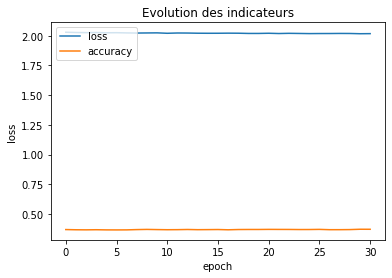

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['accuracy'])
plt.title('Evolution des indicateurs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()

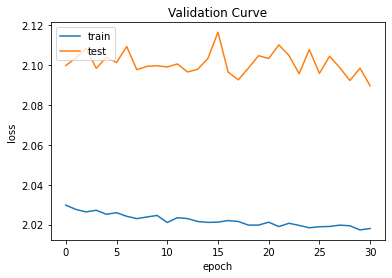

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Validation Curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

3 eme Model

In [ ]:
model.fit(x, y, batch_size=32, epochs=50, validation_split=0.2, callbacks=[callbacks_list, early_stop])


Epoch 1/50
787/787 [==============================] - 4s 5ms/step - loss: 2.0176 - accuracy: 0.3715 - val_loss: 2.1030 - val_accuracy: 0.3643

Epoch 00001: loss did not improve from 2.00444
Epoch 2/50
787/787 [==============================] - 4s 5ms/step - loss: 2.0170 - accuracy: 0.3715 - val_loss: 2.1085 - val_accuracy: 0.3594

Epoch 00002: loss did not improve from 2.00444
Epoch 3/50
787/787 [==============================] - 4s 5ms/step - loss: 2.0185 - accuracy: 0.3713 - val_loss: 2.0995 - val_accuracy: 0.3582

Epoch 00003: loss did not improve from 2.00444
Epoch 4/50
787/787 [==============================] - 4s 5ms/step - loss: 2.0175 - accuracy: 0.3711 - val_loss: 2.0983 - val_accuracy: 0.3644

Epoch 00004: loss did not improve from 2.00444
Epoch 5/50
787/787 [==============================] - 4s 5ms/step - loss: 2.0171 - accuracy: 0.3725 - val_loss: 2.0954 - val_accuracy: 0.3644

Epoch 00005: loss did not improve from 2.00444
Epoch 6/50
787/787 [==============================

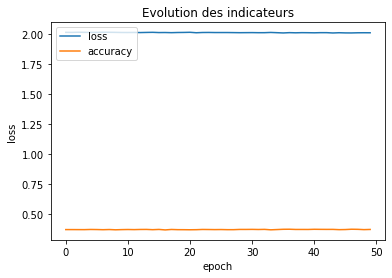

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['accuracy'])
plt.title('Evolution des indicateurs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()

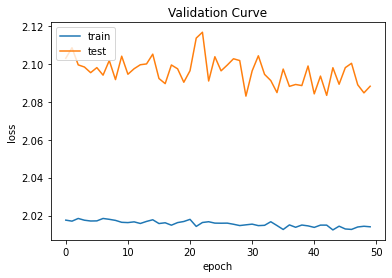

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Validation Curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 16 neurones

In [ ]:
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer



In [ ]:
tokenizer = Tokenizer()
#tokenizer.fit_on_texts(lines)
#sequences_num = tokenizer.texts_to_sequences(lines)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# build the model: a single LSTM
model2 = Sequential()
model2.add(Embedding(vocab_size, 50 , input_shape=(maxlen, len(chars))

model2.add(LSTM(16, return_sequences=True)) # input_shape=(maxlen, len(chars))

model2.add(Dense(len(chars), activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01), metrics=['accuracy'])

model2.summary()

SyntaxError: ignored

In [ ]:
model2.fit(x, y, batch_size=32, epochs=50, validation_split=0.6, callbacks=[callbacks_list, early_stop])


Epoch 1/50
394/394 [==============================] - 5s 8ms/step - loss: 2.7869 - accuracy: 0.2086 - val_loss: 2.3224 - val_accuracy: 0.2955

Epoch 00001: loss did not improve from 1.77177
Epoch 2/50
394/394 [==============================] - 3s 8ms/step - loss: 2.2680 - accuracy: 0.3072 - val_loss: 2.1994 - val_accuracy: 0.3199

Epoch 00002: loss did not improve from 1.77177
Epoch 3/50
394/394 [==============================] - 3s 8ms/step - loss: 2.1289 - accuracy: 0.3371 - val_loss: 2.1381 - val_accuracy: 0.3276

Epoch 00003: loss did not improve from 1.77177
Epoch 4/50
394/394 [==============================] - 3s 8ms/step - loss: 2.0802 - accuracy: 0.3532 - val_loss: 2.1164 - val_accuracy: 0.3355

Epoch 00004: loss did not improve from 1.77177
Epoch 5/50
394/394 [==============================] - 3s 8ms/step - loss: 2.0330 - accuracy: 0.3613 - val_loss: 2.0784 - val_accuracy: 0.3498

Epoch 00005: loss did not improve from 1.77177
Epoch 6/50
394/394 [==============================

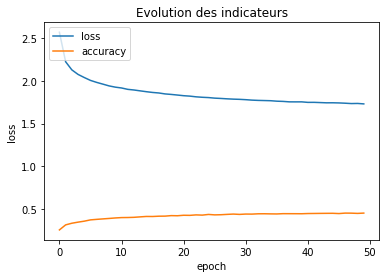

In [ ]:
plt.plot(model2.history.history['loss'])
plt.plot(model2.history.history['accuracy'])
plt.title('Evolution des indicateurs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()

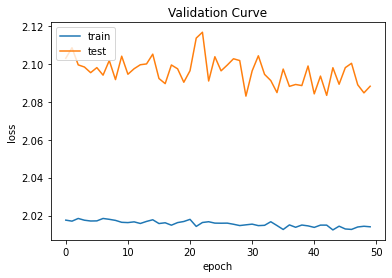

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Validation Curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.fit(x, y, batch_size=32, epochs=50, validation_split=0.2, callbacks=[callbacks_list, early_stop])


Epoch 1/50
656/787 [========================>.....] - ETA: 0s - loss: 1.7128 - accuracy: 0.6171

KeyboardInterrupt: ignored

In [ ]:
model.fit(x, y, batch_size=32, epochs=1000, validation_split=0.2, callbacks=[callbacks_list, early_stop])


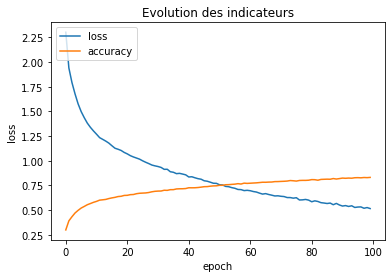

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['accuracy'])
plt.title('Evolution des indicateurs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Validation Curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.fit(x, y, batch_size=64, epochs=1000, validation_split=0.2, callbacks=[callbacks_list, early_stop])


In [ ]:
def generate_text(length, diversity):
    # Get random starting text
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    for i in range(length):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char
    return generated

#Now we can create text by j

In [ ]:
print(generate_text(500, 0.2))

In [ ]:
model.save('./MyModel_h5.h5', save_format='h5')
loaded_model_h5 = load_model('./MyModel_h5.h5')

In [ ]:
load_model

<function tensorflow.python.keras.saving.save.load_model>

In [ ]:
loaded_model_h5

In [ ]:
# loading the saved model
loaded_model.load_weights('weights-improvement-101-0.5557-bigger.hdf5')

NameError: ignored

In [ ]:
# fonction meilleur caracthere
# Defining a utility function to generate new and random raw_text based on the network's learnings 
def generate_raw_text(length, diversity): 
    # Get random starting raw_text 
    start_index = random.randint(0, len(raw_text) - maxlen - 1) #il prend un départ aléatoire dans le texte
    generated = '' #on créer une variable vide
    sentence = raw_text[start_index: start_index + maxlen] #Il prend le début de la phrase generer et creer la sequence
    generated += sentence #on insere la sentence dans la variable generated
    for i in range(length): 
            x_pred = np.zeros((1, maxlen, len(chars))) 
            for t, char in enumerate(sentence): #Il se sert du dictionnaire qui transforme le text en chiffre et inversement
                x_pred[0, t, char_indices[char]] = 1.
  
            preds = loaded_model.predict(x_pred, verbose = 0)[0] #Nous lançons notre fonction sample_index
            next_index = sample_index(preds, diversity) #il se sert du dictionnaire qui génére les caractères
            next_char = indices_char[next_index] 
  
            generated += next_char #Il créer le texte en ajoutant lettre par lettre
            sentence = sentence[1:] + next_char 
    return generated 
  
print(generate_raw_text(2000, 0.2)) 

NameError: ignored

In [ ]:
!pip install params

In [ ]:
!pip install data

  Created wheel for data: filename=data-0.4-cp36-none-any.whl size=7247 sha256=1d7239da7a2dcd763e97cd26a82a81c961c2449d8e25245c80bc181b774468dd
  Stored in directory: /root/.cache/pip/wheels/f6/09/e5/5afbc45fb0de471541092c7cd8b48d3483be68b1890955e6b9
Successfully built data


In [ ]:
from starlette.applications import Starlette
from starlette.responses import UJSONResponse
import gpt_2_simple as gpt2
import tensorflow as tf
import uvicorn
import os
import gc


app = Starlette(debug=False)

sess = gpt2.start_tf_sess(threads=1)

response_header = {
    'Access-Control-Allow-Origin': '*'
}


@app.route('/', methods=['GET', 'POST', 'HEAD'])
async def homepage(request):
    global generate_count
    global sess

    if request.method == 'GET':
        params = request.query_params
    elif request.method == 'POST':
        params = await request.json()
    elif request.method == 'HEAD':
        return UJSONResponse({'text': ''},
                             headers=response_header)
    
    gpt2.load_gpt2(sess, run_name=params.get('run_name', ''))

    text = gpt2.generate(sess,
                         run_name=params.get('run_name', ''),
                         length=int(params.get('length', 1023)),
                         temperature=float(params.get('temperature', 0.7)),
                         top_k=int(params.get('top_k', 0)),
                         top_p=float(params.get('top_p', 0)),
                         prefix=params.get('prefix', '')[:500],
                         truncate=params.get('truncate', None),
                         include_prefix=str(params.get('include_prefix', True)).lower() == 'true',
                         return_as_list=True)[0]

    sess = gpt2.reset_session(sess)

    gc.collect()
    return UJSONResponse({'text': text},
                         headers=response_header)


if __name__ == '__main__':
    uvicorn.run(app, host='0.0.0.0', port=int(os.environ.get('PORT', 8080)))

In [ ]:
from keras.models import Sequential, load_model
import numpy as np
import argparse

#from params import PRED_LEN, SEQ_LEN
from data import FIRST_SENTENCE, CHAR_INDEX, INDEX_CHAR, NB_CHARS
from processing import encode


#np.random.seed(80)


# Sampling dans la distribution de probabilités prédite
def sample(preds, temperature=1.0, do_sample=True):
    # Avec sampling
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    # Sans sampling
    preds = np.reshape(preds, (1, preds.shape[0]))
    if do_sample:
        return np.argmax(probas)
    else:
        return np.argmax(preds)


def predict_single_input(model, sentence):
    x = encode(sentence, CHAR_INDEX, NB_CHARS, float)
    x = np.reshape(x, (1, x.shape[0], x.shape[1]))
    preds = model.predict(x, verbose=0)[0]
    if len(preds.shape) > 1:
        return preds[-1]
    else:
        return preds


# Génération d'un paragraphe commençant par FIRST_SEQUENCE
def predict_paragraph(pred_len, model, do_sample=True, temperature=1.0):
    first_s = FIRST_SENTENCE
    generated = first_s
    for i in range(pred_len):
        preds = predict_single_input(model, first_s)
        next_index = sample(preds, temperature, do_sample)
        next_char = INDEX_CHAR[next_index]
        generated += next_char
        first_s = first_s[1:] + next_char
    return generated


ImportError: ignored

In [ ]:
model.save('./MyModel_h5.h5', save_format='h5')
loaded_model_h5 = load_model('./MyModel_h5.h5')

In [ ]:
loaded_model_h5

NameError: ignored

In [ ]:
# loading the saved model
loaded_model.load_weights('weights-improvement-101-0.5557-bigger.hdf5')

NameError: ignored

### Génération de text